In [2]:
import numpy as np
import pandas as pd
from math import sqrt
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

In [3]:
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,6)

In [4]:
#load that data boi
train = pd.read_csv('./data/train.csv')

In [5]:
#load that data boi
test = pd.read_csv('./data/test.csv')

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
print('# of records in train: ',len(train.index))
print('# of records in test: ',len(test.index))
print('# of columns in train: ',len(train.columns))
print('# of columns in test: ',len(test.columns))

# of records in train:  1460
# of records in test:  1459
# of columns in train:  81
# of columns in test:  80


In [9]:
#Check for missing data
print('Total missing values from train: ', sum(train.isna().sum()))
print('Total missing values from test: ', sum(test.isna().sum()))

Total missing values from train:  6965
Total missing values from test:  7000


In [10]:
#understing our variable we want to predict
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [12]:
#above shows that the majority of values fall within the 130000 - 214000 range

In [13]:
numeric_cols = train.select_dtypes(include = [np.number])
corr = numeric_cols.corr()

In [15]:
print('Most correlated features with SalePrice: '), print(corr['SalePrice'].sort_values(ascending=False)[:10],'\n')

print('Most Uncorrelated features with SalePrice:'), print(corr['SalePrice'].sort_values(ascending=False)[-5:],'\n')

Most correlated features with SalePrice: 
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

Most Uncorrelated features with SalePrice:
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64 



(None, None)

In [16]:
#Lets graph some of the most correlated features to check for outliers

Text(0.5, 0, 'GrLivArea')

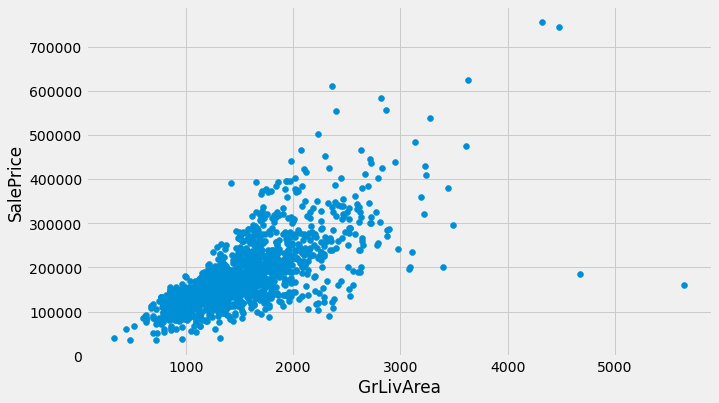

In [17]:
plt.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')

In [18]:
#couple outliers bottom right, and top right, but top right follows the linear pattern

Text(0.5, 0, 'GarageArea')

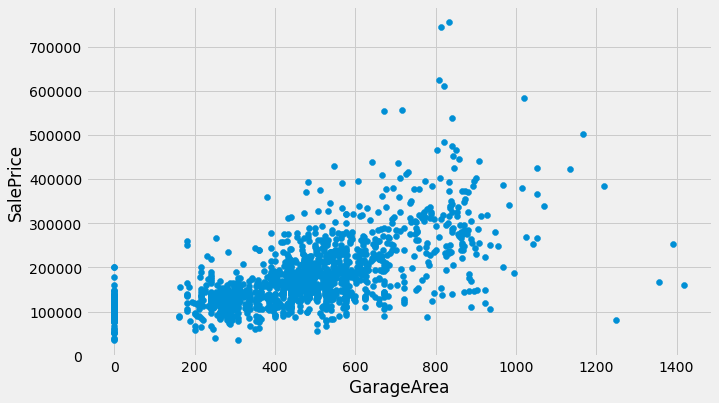

In [19]:
plt.scatter(x=train['GarageArea'],y=train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')

In [20]:
#We see quite a few houses with 0 for garage area (no garage or missing data) and a couple outliers as well.

In [21]:
#TIME FOR
#Data preprocessing

In [22]:
#removing GrLivArea outliers
train = train[train['GrLivArea'] < 4500]

In [23]:
#removing GarageArea outliers
train = train[train['GarageArea'] < 1200]

In [25]:
#now drop columns with missing values > 80%
train_per = train.isnull().sum() /train.shape[0]
print(train_per[train_per > 0.80])
train = train.drop(train_per[train_per > 0.80].index,axis=1)

Alley          0.937414
PoolQC         0.995873
Fence          0.806740
MiscFeature    0.963549
dtype: float64


In [26]:
#Same thing with the test data
test_per = test.isnull().sum() /test.shape[0]
print(test_per[test_per > 0.80])
test = test.drop(test_per[test_per > 0.80].index,axis=1)

Alley          0.926662
PoolQC         0.997944
Fence          0.801234
MiscFeature    0.965045
dtype: float64


In [28]:
#encode categorical Variables
le = preprocessing.LabelEncoder()
for name in train.columns:
    if train[name].dtypes == 'O':
        train[name] = train[name].astype(str)
        le.fit(train[name])
        train[name] = le.transform(train[name])

In [29]:
#Do the same for the test data
le = preprocessing.LabelEncoder()
for name in test.columns:
    if test[name].dtypes == 'O':
        test[name] = test[name].astype(str)
        le.fit(test[name])
        test[name] = le.transform(test[name])

In [35]:
#Handle the NaN values

In [36]:
#Fill train missing values based on probability of occurance
for column in train.columns:
    null_vls = train.isnull().values
    a, b = np.unique(train.values[~null_vls], return_counts=1)
    train.loc[train[column].isna(), column] = np.random.choice(a, train[column].isnull().sum(), p = b/b.sum())

In [37]:
#Fill test missing values based on probability of occurance
for column in test.columns:
    null_vls = test.isnull().values
    a, b = np.unique(test.values[~null_vls], return_counts=1)
    test.loc[test[column].isna(), column] = np.random.choice(a, test[column].isnull().sum(), p = b/b.sum())

In [38]:
#Time to apply some log transformations

In [39]:
skewed_train = train.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
train[skewed_train.index] = np.log1p(train[skewed_train.index])

In [ ]:
#apply the same in test
skewed_test = test.apply(lambda x: skew(x.dropna()))
skewed_test = skewed_test[skewed_test > .75]
test[skewed_test.index] = np.log1p(test[skewed_test.index])

In [40]:
#Create Linear Regression Model

In [112]:
X = train.drop(['SalePrice', 'Id'], axis=1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =.2,random_state=4)

In [113]:
lr = linear_model.LinearRegression()

In [114]:
model = lr.fit(X_train,y_train)

In [115]:
predictions = model.predict(X_test)

In [116]:
#Analyze model
print('MAE is:', mean_absolute_error(y_test,predictions))
print('MAE is:', sqrt(mean_absolute_error(y_test,predictions)))

MAE is: 0.0813586165378223
MAE is: 0.28523431865366816


Text(0.5, 1.0, 'Linear Regression Model')

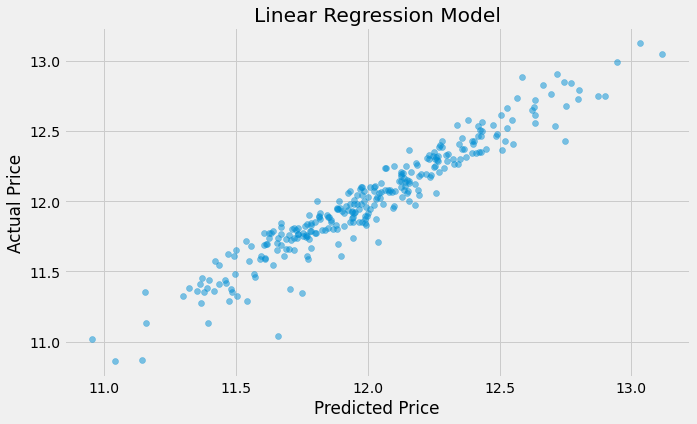

In [117]:
#plot the model
plt.scatter(predictions,y_test,alpha=.5)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')

In [118]:
#Time for the submission

In [119]:
submission = pd.DataFrame()
submission['Id'] = test['Id'].astype(int)

In [120]:
temp = test.select_dtypes(include = [np.number]).drop(['Id'],axis=1).interpolate()

In [121]:
predictions = model.predict(temp)

In [122]:
predictions = np.exp(predictions)
submission['SalePrice'] = predictions

In [123]:
submission.to_csv('submission.csv', index = False)

In [124]:
#Let's try another model

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBRegressor

In [126]:
model = XGBRegressor(base_score=0.4, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.05,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, monotone_constraints='()',
             n_estimators=2200, n_jobs=4, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, subsample=0.5213,silent = True,tree_method='exact',
             validate_parameters=1, verbosity=0)

In [127]:
pipeline = Pipeline(steps=[('impute',IterativeImputer(max_iter=2)),
                           ('scale',MinMaxScaler()),
                           ('f',PowerTransformer(method='yeo-johnson'))
                    ,('model',model)])

In [128]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('impute', IterativeImputer(max_iter=2)),
                ('scale', MinMaxScaler()), ('f', PowerTransformer()),
                ('model',
                 XGBRegressor(base_score=0.4, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.4603, gamma=0.05, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=3,
                              min_child_weight=1.7817, missing=nan,
                              monotone_constraints='()', n_estimators=2200,
                              n_jobs=4, nthread=-1, num_parallel_tree=1,
                              random_state=7, reg_alpha=0.464,
                              reg_lambda=0.8571, scale_pos_weight=1,
                              silent=True, subsample=0.5213,
                              

In [129]:
predictions = pipeline.predict(X_test)

Text(0.5, 1.0, 'XGBRegressor gbtree')

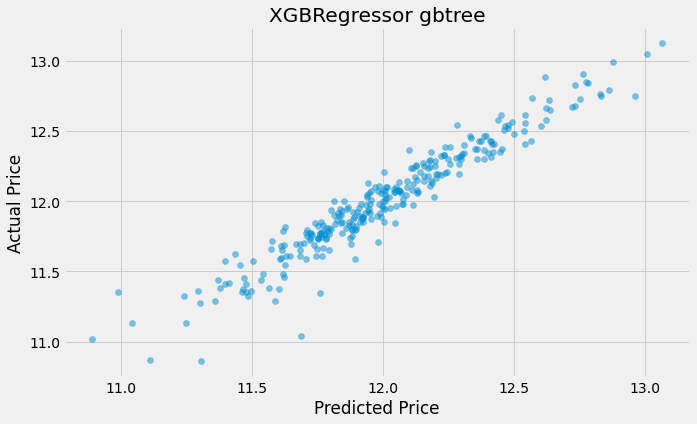

In [130]:
plt.scatter(predictions,y_test,alpha=.5)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBRegressor gbtree')

In [131]:
#Analyze model
print('MAE is:', mean_absolute_error(y_test,predictions))
print('MAE is:', sqrt(mean_absolute_error(y_test,predictions)))

MAE is: 0.07899906389703926
MAE is: 0.2810677211937352


In [132]:
yhat = pipeline.predict(temp)
yhat =np.exp(yhat)

In [133]:
submission = pd.DataFrame()
submission['Id'] = test['Id'].astype(int)
submission['SalePrice'] = yhat

In [134]:
submission.to_csv('XGBRegressor.csv', index = False)

In [135]:
#Next using the XGBRegressor without the traintest split (no analysis of model, but should allow more accurate results)

In [136]:
model = XGBRegressor(base_score=0.4, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.05,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, monotone_constraints='()',
             n_estimators=2200, n_jobs=4, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, subsample=0.5213,silent = True,tree_method='exact',
             validate_parameters=1, verbosity=0)

In [137]:
pipeline = Pipeline(steps=[('impute',IterativeImputer(max_iter=2)),
                           ('scale',MinMaxScaler()),
                           ('f',PowerTransformer(method='yeo-johnson'))
                    ,('model',model)])

In [138]:
pipeline.fit(X,y)

Pipeline(steps=[('impute', IterativeImputer(max_iter=2)),
                ('scale', MinMaxScaler()), ('f', PowerTransformer()),
                ('model',
                 XGBRegressor(base_score=0.4, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.4603, gamma=0.05, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=3,
                              min_child_weight=1.7817, missing=nan,
                              monotone_constraints='()', n_estimators=2200,
                              n_jobs=4, nthread=-1, num_parallel_tree=1,
                              random_state=7, reg_alpha=0.464,
                              reg_lambda=0.8571, scale_pos_weight=1,
                              silent=True, subsample=0.5213,
                              

In [139]:
yhat = pipeline.predict(temp)
yhat =np.exp(yhat)
submission = pd.DataFrame()
submission['Id'] = test['Id'].astype(int)
submission['SalePrice'] = yhat
submission.to_csv('XGBRegressorFullTrain.csv', index = False)